# Curve Fitting
The assignment set is expected to perform the data fitting process. In this assignemnt one of quasi-Newton optimization methods called Davidon-Fletcher-Powell method is implemented.

©Tomohiro Sasaki

## Import necessary libraries

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import random


The fitting model is
$$ Y(x) =p_{0}+p_{1} \cos (2 \pi x)+p_{2} \cos (4 \pi x)+p_{3} \cos (6 \pi x) $$

The quadratic objective function is:

$$
\begin{aligned}
    f\left(p_{0}, p_{1}, p_{2}, p_{3}\right)=\sum_{i=1}^{\textrm{data~size}}\left[p_{0}+p_{1} \cos \left(2 \pi x_{i}\right)+p_{2} \cos \left(4 \pi x_{i}\right)+p_{3} \cos \left(6 \pi x_{i}\right)-y_{i}\right]^{2}
\end{aligned}
$$

In [18]:
def obj(p, x, y):
    n = np.size(y)

    f = 0
    for i in range(n):
        f += (p[0] + p[1]*np.cos(2*np.pi*x[i]) + p[2]*np.cos(4*np.pi*x[i]) + p[3]*np.cos(6*np.pi*x[i]) - y[i])**2
    return f

Compute the first derivative of the objective function:

In [12]:
p0, p1, p2, p3, x, y = sp.symbols('p0 p1 p2 p3 x y')
Y = p0 + p1 * sp.cos(2 * sp.pi * x) + p2 * sp.cos(4 * sp.pi * x) + p3 * sp.cos(6 * sp.pi * x) - y
f = Y**2
print('f = ', f)
print('df/dp0 = ', sp.diff(f, p0))
print('df/dp1 = ', sp.diff(f, p1))
print('df/dp2 = ', sp.diff(f, p2))
print('df/dp3 = ', sp.diff(f, p3))

f =  (p0 + p1*cos(2*pi*x) + p2*cos(4*pi*x) + p3*cos(6*pi*x) - y)**2
df/dp0 =  2*p0 + 2*p1*cos(2*pi*x) + 2*p2*cos(4*pi*x) + 2*p3*cos(6*pi*x) - 2*y
df/dp1 =  2*(p0 + p1*cos(2*pi*x) + p2*cos(4*pi*x) + p3*cos(6*pi*x) - y)*cos(2*pi*x)
df/dp2 =  2*(p0 + p1*cos(2*pi*x) + p2*cos(4*pi*x) + p3*cos(6*pi*x) - y)*cos(4*pi*x)
df/dp3 =  2*(p0 + p1*cos(2*pi*x) + p2*cos(4*pi*x) + p3*cos(6*pi*x) - y)*cos(6*pi*x)


In [40]:
def grad(p, x, y):
    n = np.size(y)

    g = np.zeros(4)
    for i in range(n):
        g += np.array([
            2*p[0] + 2*p[1]*np.cos(2*np.pi*x[i]) + 2*p[2]*np.cos(4*np.pi*x[i]) + 2*p[3]*np.cos(6*np.pi*x[i]) - 2*y[i],
            2*(p[0] + p[1]*np.cos(2*np.pi*x[i]) + p[2]*np.cos(4*np.pi*x[i]) + p[3]*np.cos(6*np.pi*x[i]) - y[i])*np.cos(2*np.pi*x[i]),
            2*(p[0] + p[1]*np.cos(2*np.pi*x[i]) + p[2]*np.cos(4*np.pi*x[i]) + p[3]*np.cos(6*np.pi*x[i]) - y[i])*np.cos(4*np.pi*x[i]),
            2*(p[0] + p[1]*np.cos(2*np.pi*x[i]) + p[2]*np.cos(4*np.pi*x[i]) + p[3]*np.cos(6*np.pi*x[i]) - y[i])*np.cos(6*np.pi*x[i])
        ])

    return g



## DFP Algorithm

### Algorithmi Flow
Given an initial guess $\mathbf{x}_0$ and an approximate Hessian matrix $B_0$, repeat the following processes:

1. Compute a descent direction $\mathbf{d}_k$ from $B_k \mathbf{d}_k = - \nabla f(\mathbf{x}_k)$
2. Perform a line search to find an acceptable stepsize $\alpha_k$ in the descent direction. The stepsize suffices Wolfe conditions.
3. Set $\mathbf{s}_k = \alpha_k \mathbf{d}_k$ and update $\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{s}_k$
4. Compute $\mathbf{r}_k = \nabla f\left(\mathbf{x}_{k+1}\right)-\nabla f\left(\mathbf{x}_{k}\right)$
5. $B_{k+1}=\left(I-\gamma_{k} r_{k} s_{k}^{T}\right) B_{k}\left(I-\gamma_{k} r_{k} y_{k}^{T}\right)+\gamma_{k} r_{k} r_{k}^{T}$
   
   where $1/y_k^{T}s_k$

In [103]:
def fit(x, y, epsilon=0.001, initial_guess=None, max_ite=100):
    '''
    Curve fitting using a quasi-Newton optimization method, called Davidon-Fletcher-Powell (DFP) method 
    Args:
            x (1 x n array): dataset for the model function variable
            y (1 x n array): dataset for the model function
            epsilon (float): convergence criteria
            initial_guess (1 x 4 array): initial guess for coefficients
            max_ite: maximum iteration

        Returns:
            numpy array of fitted coefficients p = [p0, p1, p2, p3]
    '''
    if initial_guess is None:
        initial_guess = np.array([1, 1, 1, 1])
    p = initial_guess

    df = grad(p, x, y) # gradient
    B = np.linalg.norm(df) * np.eye(4)  # initial Hessian approximation

    ite_out = 0
    while np.linalg.norm(df) > epsilon and ite_out <= max_ite:
        d = - np.linalg.inv(B) @ df # compute descent direction
        
        alp = 1
        f = obj(p, x, y)
        f_alp = obj(p + alp*d, x, y) 
        ite_in = 0
        tau = 1/2

        # perform inexact line search (back-tracking line search)
        while f_alp < f and ite_in < 30:
            # check Armijo condition
            c1 = 10**-3
            if f_alp <= f + c1 * alp * p @ df:
                # check curvature condition
                # c2 = random.uniform(c1, 1)
                c2 = 10**-1
                if grad(p + alp*d, x, y) @ p >= c2 * df @ p:
                    break
                    # check strong Wolfe curvature condition
                    if abs(p @ grad(p + alp*d, x, y)) <= c2 * abs(p @ df):
                        break
            
            alp = tau * alp # update stepsize
            f_alp = obj(p + alp*d, x, y) 
            ite_in += 1 
        
        p_old = p
        s = alp * d
        p = p_old + s # updated variables
        df_old = df
        df = grad(p, x, y) # updated gradient

        r = df - df_old

        # BFGS update
        # B += r.reshape(-1,1) @ r.reshape(1,4) / (r @ s) - (B @ s).reshape(-1,1) @ (s @ B.T).reshape(1,4) / (s @ B @ s)
        
        # DFP update
        gam = 1/(r @ s)
        B = (np.eye(4) - gam * r.reshape(-1,1) @ s.reshape(1,4)) * B * (np.eye(4) \
            - gam * r.reshape(-1,1) @ s.reshape(1,4)) + gam * r.reshape(-1,1) @ r.reshape(1,4)

        ite_out += 1
    
    return p

popt_dfp = fit(x,y)
popt_dfp



array([ 2.01205043,  3.00655189, -0.03737356,  0.98631167])

## RUN DFP fitting

In [16]:
# Fixing random state for reproducibility
np.random.seed(19680801)

dx = 0.1
x_lower_limit = 0
x_upper_limit = 40                                       
x = np.arange(x_lower_limit, x_upper_limit, dx)
data_size = len(x)                                 # data size
noise = np.random.randn(data_size)                 # white noise

# Original dataset 
y = 2.0 + 3.0*np.cos(2*np.pi*x) + 1.0*np.cos(6*np.pi*x) + noise
y_true = 2.0 + 3.0*np.cos(2*np.pi*x) + 1.0*np.cos(6*np.pi*x) 


No handles with labels found to put in legend.


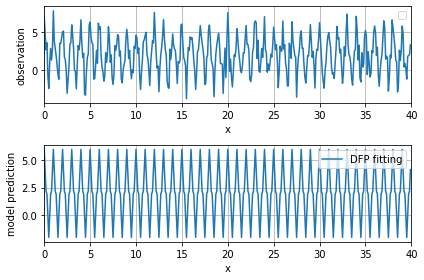

In [109]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(x, y, label='')
# axs[0].plot(x, y_true, label='')
axs[0].set_xlim(x_lower_limit, x_upper_limit)
axs[0].set_xlabel('x')
axs[0].set_ylabel('observation')
axs[0].legend()
axs[0].grid(True)

#########################################
## Plot the predictions from your fitted model here
axs[1].plot(x, func(x,*popt_dfp), label='DFP fitting')
axs[1].set_xlim(x_lower_limit, x_upper_limit)
axs[1].set_xlabel('x')
axs[1].set_ylabel('model prediction')
axs[1].legend()
axs[1].grid(True)
fig.tight_layout()
plt.show()

## Solution using Scipy

This section is for comparison of solutions from DFP_fit() and Scipy.curve_fit()

In [19]:
from scipy.optimize import curve_fit

def func(x, p0, p1, p2, p3):
    return p0 + p1*np.cos(2*np.pi*x) + p2*np.cos(4*np.pi*x) + p3*np.cos(6*np.pi*x)

popt, pcov = curve_fit(func, x, y)
popt

array([ 2.01211971,  3.00663202, -0.03737355,  0.98631165])

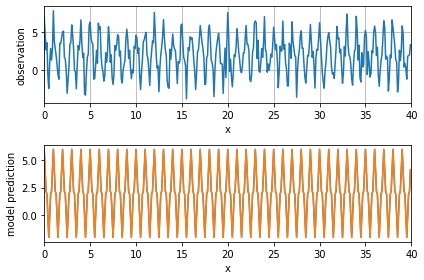

In [111]:

fig, axs = plt.subplots(2, 1)
axs[0].plot(x, y)
axs[0].set_xlim(x_lower_limit, x_upper_limit)
axs[0].set_xlabel('x')
axs[0].set_ylabel('observation')
axs[0].grid(True)

#########################################
## Plot the predictions from your fitted model here
axs[1].plot(x, func(x,*popt), label='Scipy fitting')
axs[1].plot(x, func(x,*popt_dfp), label='DFP fitting')
# plt.plot(xdata, func(xdata, *popt), 'g--',
# ...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

axs[1].set_xlim(x_lower_limit, x_upper_limit)
axs[1].set_xlabel('x')
axs[1].set_ylabel('model prediction')

fig.tight_layout()
plt.show()
